<a href="https://colab.research.google.com/github/aldajani0/Ghiras_data_prep-/blob/main/Ghiras_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import os
import zipfile
import shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import tensorflow as tf
import json

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
zip_path = "/content/drive/MyDrive/Ghiras_dataset/data_split.zip"
extract_path = "/content/dataset"


# Delete the old folder if it exists
if os.path.exists(extract_path):
    shutil.rmtree(extract_path)
    print("  • Deleted the old folder")

# Extract the zip file
print(f"  • Extracting from: {zip_path}")
print(f"  • To: {extract_path}")

os.system(f'unzip -q "{zip_path}" -d "{extract_path}"')

print(" Extraction successful\n")


  • Deleted the old folder
  • Extracting from: /content/drive/MyDrive/Ghiras_dataset/data_split.zip
  • To: /content/dataset
 Extraction successful



In [28]:
!ls -R /content/dataset | head -50

/content/dataset:
data_split copy
__MACOSX

/content/dataset/data_split copy:
test
train
val

/content/dataset/data_split copy/test:
Apple_Apple_scab
Apple_Black_rot
Apple_Cedar_apple_rust
Apple_healthy
banana_Cordana_leaf_spot
banana_healthy
banana_pestalotiopsis
banana_sigatoka
bean_angular_leaf_spot
bean_healthy
bean_rust
Blueberry_healthy
Cherry_healthy
Cherry_Powdery_mildew
chili_Bacterial_Spot
chili_Cercospora_Leaf_Spot
chili_Curl_Virus
chili_Healthy
chili_Nutrition_Deficiency
chili_White_spot
Corn_Cercospora_leaf_spot Gray_leaf_spot
Corn_Common_rust_
Corn_healthy
Corn_Northern_Leaf_Blight
CucumberـAnthracnose
Cucumber ـBacterialـWilt
CucumberـBelly Rot
CucumberـDownyـMildew
Cucumber_Gummy_Stem_Blight
Cucumberـhealthy
Cucumber_Pythium_Fruit_Rot
Downy_mildew_on_lettuce
Grape_Black_rot
Grape_Esca_(Black_Measles)
Grape_healthy
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Lemon_Anthracnose
Lemon_Black_Spot
Lemon_Citrus_Canker
Lemon_Citrus_Leaf_Miner


 نطالع الهيكلة ونتأكد إنها نفس اللي نحتاجها

In [29]:
DATA_DIR = Path("/content/dataset/data_split copy")

train_dir = DATA_DIR / "train"
val_dir   = DATA_DIR / "val"
test_dir  = DATA_DIR / "test"

print("Does train exist? ", train_dir.exists())
print("Does val exist?   ", val_dir.exists())
print("Does test exist?  ", test_dir.exists())

print("\nSample classes inside train/:")
train_classes = [p.name for p in train_dir.iterdir() if p.is_dir()]
print(train_classes[:10], "... (total:", len(train_classes), "classes)")

Does train exist?  True
Does val exist?    True
Does test exist?   True

Sample classes inside train/:
['Corn_Northern_Leaf_Blight', 'LettuceـHealthy', 'Tomato_Bacterial_spot', 'plam_Magnesium_Deficiency', 'Corn_Cercospora_leaf_spot Gray_leaf_spot', 'Peach_healthy', 'Blueberry_healthy', 'Lemon_Greening', 'Orange_Haunglongbing_(Citrus_greening)', 'chili_Cercospora_Leaf_Spot'] ... (total: 96 classes)


نعد كم صورة عندنا للتأكد من سلامة الداتا

In [30]:
def count_images_in_dir(d: Path):
    exts = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp"}
    total = 0
    for cls in d.iterdir():
        if cls.is_dir():
            for f in cls.iterdir():
                if f.is_file() and f.suffix.lower() in exts:
                    total += 1
    return total

print("Train image count:", count_images_in_dir(train_dir))
print("Val image count:  ", count_images_in_dir(val_dir))
print("Test image count: ", count_images_in_dir(test_dir))

Train image count: 141809
Val image count:   8367
Test image count:  8367


نحمل البيانات باستخدام Keras ونشوف Batch عيّنة

In [31]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16  # مخفض للذاكرة
SEED = 42

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

class_names = train_ds.class_names
num_classes = len(class_names)

print("\n  Number of classes:", num_classes)
print("Class names (first 10):", class_names[:10])


Found 141809 files belonging to 96 classes.
Found 8367 files belonging to 96 classes.
Found 8367 files belonging to 96 classes.

  Number of classes: 96
Class names (first 10): ['Apple_Apple_scab', 'Apple_Black_rot', 'Apple_Cedar_apple_rust', 'Apple_healthy', 'Blueberry_healthy', 'Cherry_Powdery_mildew', 'Cherry_healthy', 'Corn_Cercospora_leaf_spot Gray_leaf_spot', 'Corn_Common_rust_', 'Corn_Northern_Leaf_Blight']


In [32]:
with open('/content/class_names.json', 'w', encoding='utf-8') as f:
    json.dump(class_names, f, ensure_ascii=False, indent=2)
print(" Class names saved to /content/class_names.json")


 Class names saved to /content/class_names.json


عشان الترست ايشوز اللي عندي بس نعرض شوية صور ونسوماتها

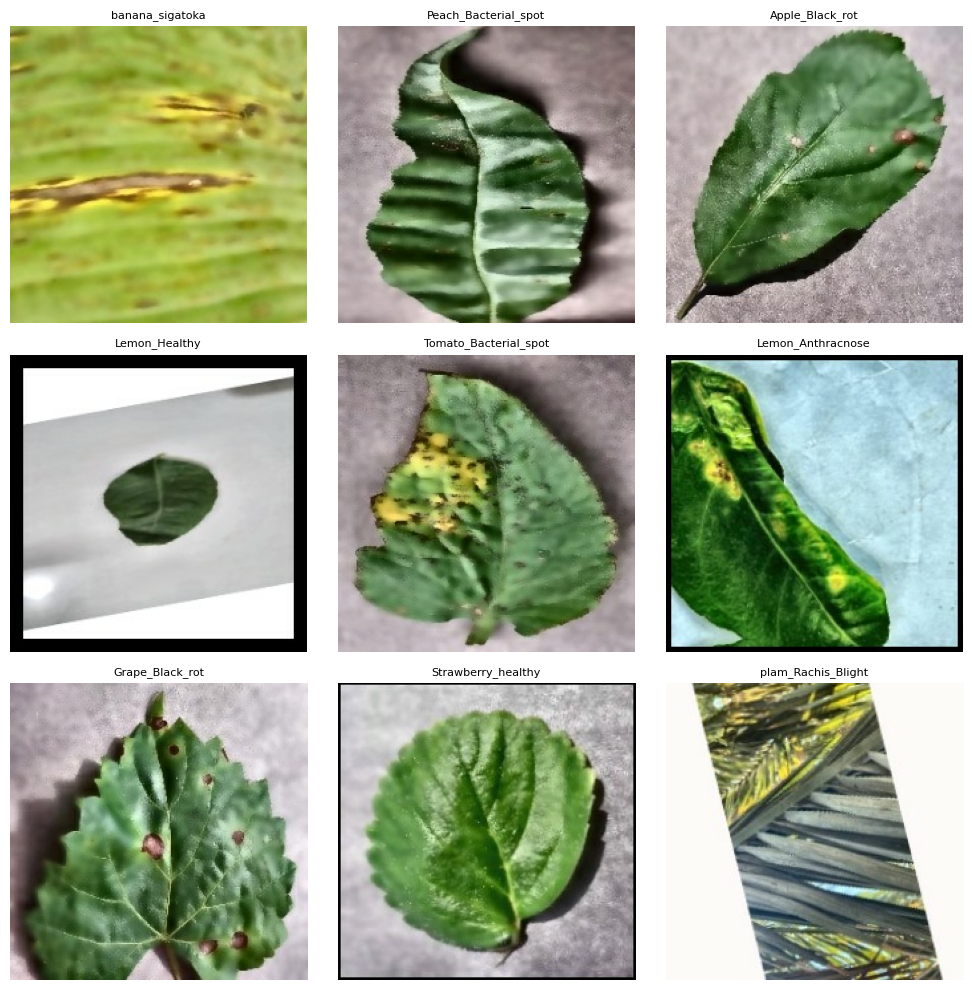

In [33]:
plt.figure(figsize=(10,10))
for imgs, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        img = imgs[i].numpy().astype("uint8")
        plt.imshow(img)
        label_index = labels[i].numpy().argmax()
        plt.title(class_names[label_index], fontsize=8)
        plt.axis("off")
plt.tight_layout()
plt.show()


بسم الله بنحط المودل

حساب Class Weights (للتعامل مع Imbalanced Data)


In [34]:
from sklearn.utils.class_weight import compute_class_weight

print("\n Computing class weights...")
labels_list = []
for _, labels in train_ds.unbatch().batch(1000).take(5):  # عينة للسرعة
    labels_list.extend(np.argmax(labels.numpy(), axis=1))

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(labels_list),
    y=labels_list
)
class_weights_dict = dict(enumerate(class_weights))
print(" Class weights computed")



 Computing class weights...
 Class weights computed


In [35]:
# Prefetching & Caching
AUTOTUNE = tf.data.AUTOTUNE # هذي تخلي التدريب أسرع لأنها تجهز الباتشات مسبقاً

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)  # بدون cache
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [36]:
# Data Augmentation
# هذي طبقات تطبق تعديلات عشوائية على الصور وقت التدريب بس

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness(0.1),
], name="data_augmentation")

بناء المودل  Transfer Learning

In [42]:
from tensorflow.keras import layers, models

print("\n Building Transfer Learning Model (EfficientNetB0)...")

# تحميل Base Model المدرب مسبقاً
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# تجميد أوزان Base Model
base_model.trainable = False

# بناء المودل الكامل
inputs = layers.Input(shape=(224, 224, 3))

# Data Augmentation (على الصور الأصلية)
x = data_augmentation(inputs)

# EfficientNet Preprocessing (مهم جداً!)
x = tf.keras.applications.efficientnet.preprocess_input(x)

# Base Model (Pre-trained)
x = base_model(x)

# Custom Head
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)

# Output Layer
outputs = layers.Dense(num_classes, activation='softmax', name='output')(x)

# إنشاء المودل
model = models.Model(inputs=inputs, outputs=outputs, name='PlantDiseaseModel_TransferLearning')

print(" Model built successfully!")



 Building Transfer Learning Model (EfficientNetB0)...
 Model built successfully!


Compile المودل

In [43]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_accuracy')]
)

model.summary()

Model: "PlantDiseaseModel_TransferLearning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 96)             │        24,672 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,868,611 (18.57 MB)

 Trainable params: 815,456 (3.11 MB)

 Non-trainable params: 4,053,155 (15.46 MB)

Callbacks (Early Stopping, ModelCheckpoint, etc.)

In [44]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='/content/best_model.keras',
        monitor='val_accuracy',  # نراقب الـ accuracy بدل loss
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )
]

 تدريب المودل

In [46]:
#  المرحلة الأولى تدريب Head فقط
EPOCHS_STAGE1 = 15

print("\n" + "="*70)
print(" STAGE 1: Training Custom Head (Base Model Frozen)")
print("="*70 + "\n")

history_stage1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    callbacks=callbacks,
    verbose=1
)

print("\n Stage 1 completed!")



 STAGE 1: Training Custom Head (Base Model Frozen)

Epoch 1/15
8864/8864 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6046 - loss: 1.3615 - top5_accuracy: 0.8850
Epoch 1: val_accuracy improved from -inf to 0.89973, saving model to /content/best_model.keras
8864/8864 ━━━━━━━━━━━━━━━━━━━━ 497s 56ms/step - accuracy: 0.6046 - loss: 1.3615 - top5_accuracy: 0.8850 - val_accuracy: 0.8997 - val_loss: 0.2970 - val_top5_accuracy: 0.9947 - learning_rate: 5.0000e-04
Epoch 2/15
8864/8864 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7748 - loss: 0.6724 - top5_accuracy: 0.9756
Epoch 2: val_accuracy improved from 0.89973 to 0.90702, saving model to /content/best_model.keras
8864/8864 ━━━━━━━━━━━━━━━━━━━━ 494s 56ms/step - accuracy: 0.7748 - loss: 0.6724 - top5_accuracy: 0.9756 - val_accuracy: 0.9070 - val_loss: 0.2629 - val_top5_accuracy: 0.9958 - learning_rate: 5.0000e-04
Epoch 3/15
8864/8864 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8027 - loss: 0.5894 - top5_accuracy: 0.9810
Epoch 3: va

In [ ]:
#المرحلة الثانية: Fine-tuning
"""
print("\n" + "="*70)
print("STAGE 2: Fine-tuning (Unfreezing last layers)")
print("="*70 + "\n")

# فك تجميد آخر 20 طبقة من Base Model
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

print(f"Total layers: {len(base_model.layers)}")
print(f"Trainable layers: {sum([layer.trainable for layer in base_model.layers])}")

# إعادة Compile بـ Learning Rate أقل
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_accuracy')]
)

EPOCHS_STAGE2 = 5

history_stage2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE2,
    callbacks=callbacks,
    class_weight=class_weights_dict,
    verbose=1
)

print("\n Stage 2 completed!")

# دمج تاريخ المرحلتين
history_combined = {
    'accuracy': history_stage1.history['accuracy'] + history_stage2.history['accuracy'],
    'val_accuracy': history_stage1.history['val_accuracy'] + history_stage2.history['val_accuracy'],
    'loss': history_stage1.history['loss'] + history_stage2.history['loss'],
    'val_loss': history_stage1.history['val_loss'] + history_stage2.history['val_loss'],
}
"""


رسم منحنيات التدريب

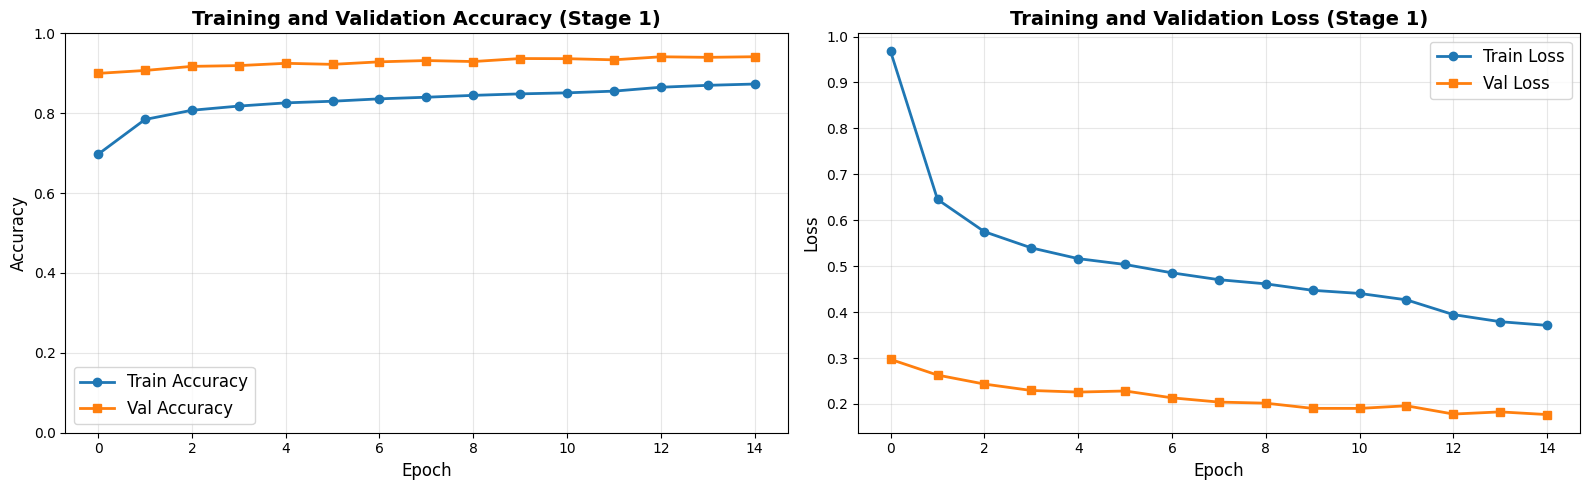


 Stage 1 Training Summary:
   Final Train Accuracy: 87.31%
   Final Val Accuracy: 94.14%
   Best Val Accuracy: 94.14%
   Final Train Loss: 0.3710
   Final Val Loss: 0.1768


In [51]:
acc = history_stage1.history['accuracy']        # ← .history مهمة!
val_acc = history_stage1.history['val_accuracy']
loss = history_stage1.history['loss']
val_loss = history_stage1.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy', linewidth=2, marker='o')
plt.plot(epochs_range, val_acc, label='Val Accuracy', linewidth=2, marker='s')
plt.legend(fontsize=12)
plt.title('Training and Validation Accuracy (Stage 1)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim([0, 1])

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss', linewidth=2, marker='o')
plt.plot(epochs_range, val_loss, label='Val Loss', linewidth=2, marker='s')
plt.legend(fontsize=12)
plt.title('Training and Validation Loss (Stage 1)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# طباعة ملخص
print("\n Stage 1 Training Summary:")
print("="*70)
print(f"   Final Train Accuracy: {acc[-1]*100:.2f}%")
print(f"   Final Val Accuracy: {val_acc[-1]*100:.2f}%")
print(f"   Best Val Accuracy: {max(val_acc)*100:.2f}%")
print(f"   Final Train Loss: {loss[-1]:.4f}")
print(f"   Final Val Loss: {val_loss[-1]:.4f}")
print("="*70)

تقييم سريع على Test Set

In [52]:
test_results = model.evaluate(test_ds, verbose=1)
print(f"\n Test Accuracy: {test_results[1]*100:.2f}%")
print(f" Test Top-5 Accuracy: {test_results[2]*100:.2f}%")
print(f" Test Loss: {test_results[0]:.4f}")

523/523 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.9629 - loss: 0.1069 - top5_accuracy: 0.9982

 Test Accuracy: 94.78%
 Test Top-5 Accuracy: 99.68%
 Test Loss: 0.1575


Confusion Matrix & Classification Report


 Generating predictions on test set...
 Total classes in dataset: 96
 Classes present in test set: 94
  Missing classes: 2

 CLASSIFICATION REPORT:
                                             precision    recall  f1-score   support

                           Apple_Apple_scab      0.984     0.948     0.966       252
                            Apple_Black_rot      0.961     0.996     0.978       249
                     Apple_Cedar_apple_rust      0.991     0.982     0.986       220
                              Apple_healthy      0.984     0.980     0.982       250
                          Blueberry_healthy      0.989     0.994     0.992       181
                      Cherry_Powdery_mildew      1.000     0.959     0.979       169
                             Cherry_healthy      1.000     0.989     0.994       182
   Corn_Cercospora_leaf_spot Gray_leaf_spot      0.946     0.970     0.958       164
                          Corn_Common_rust_      1.000     1.000     1.000       190


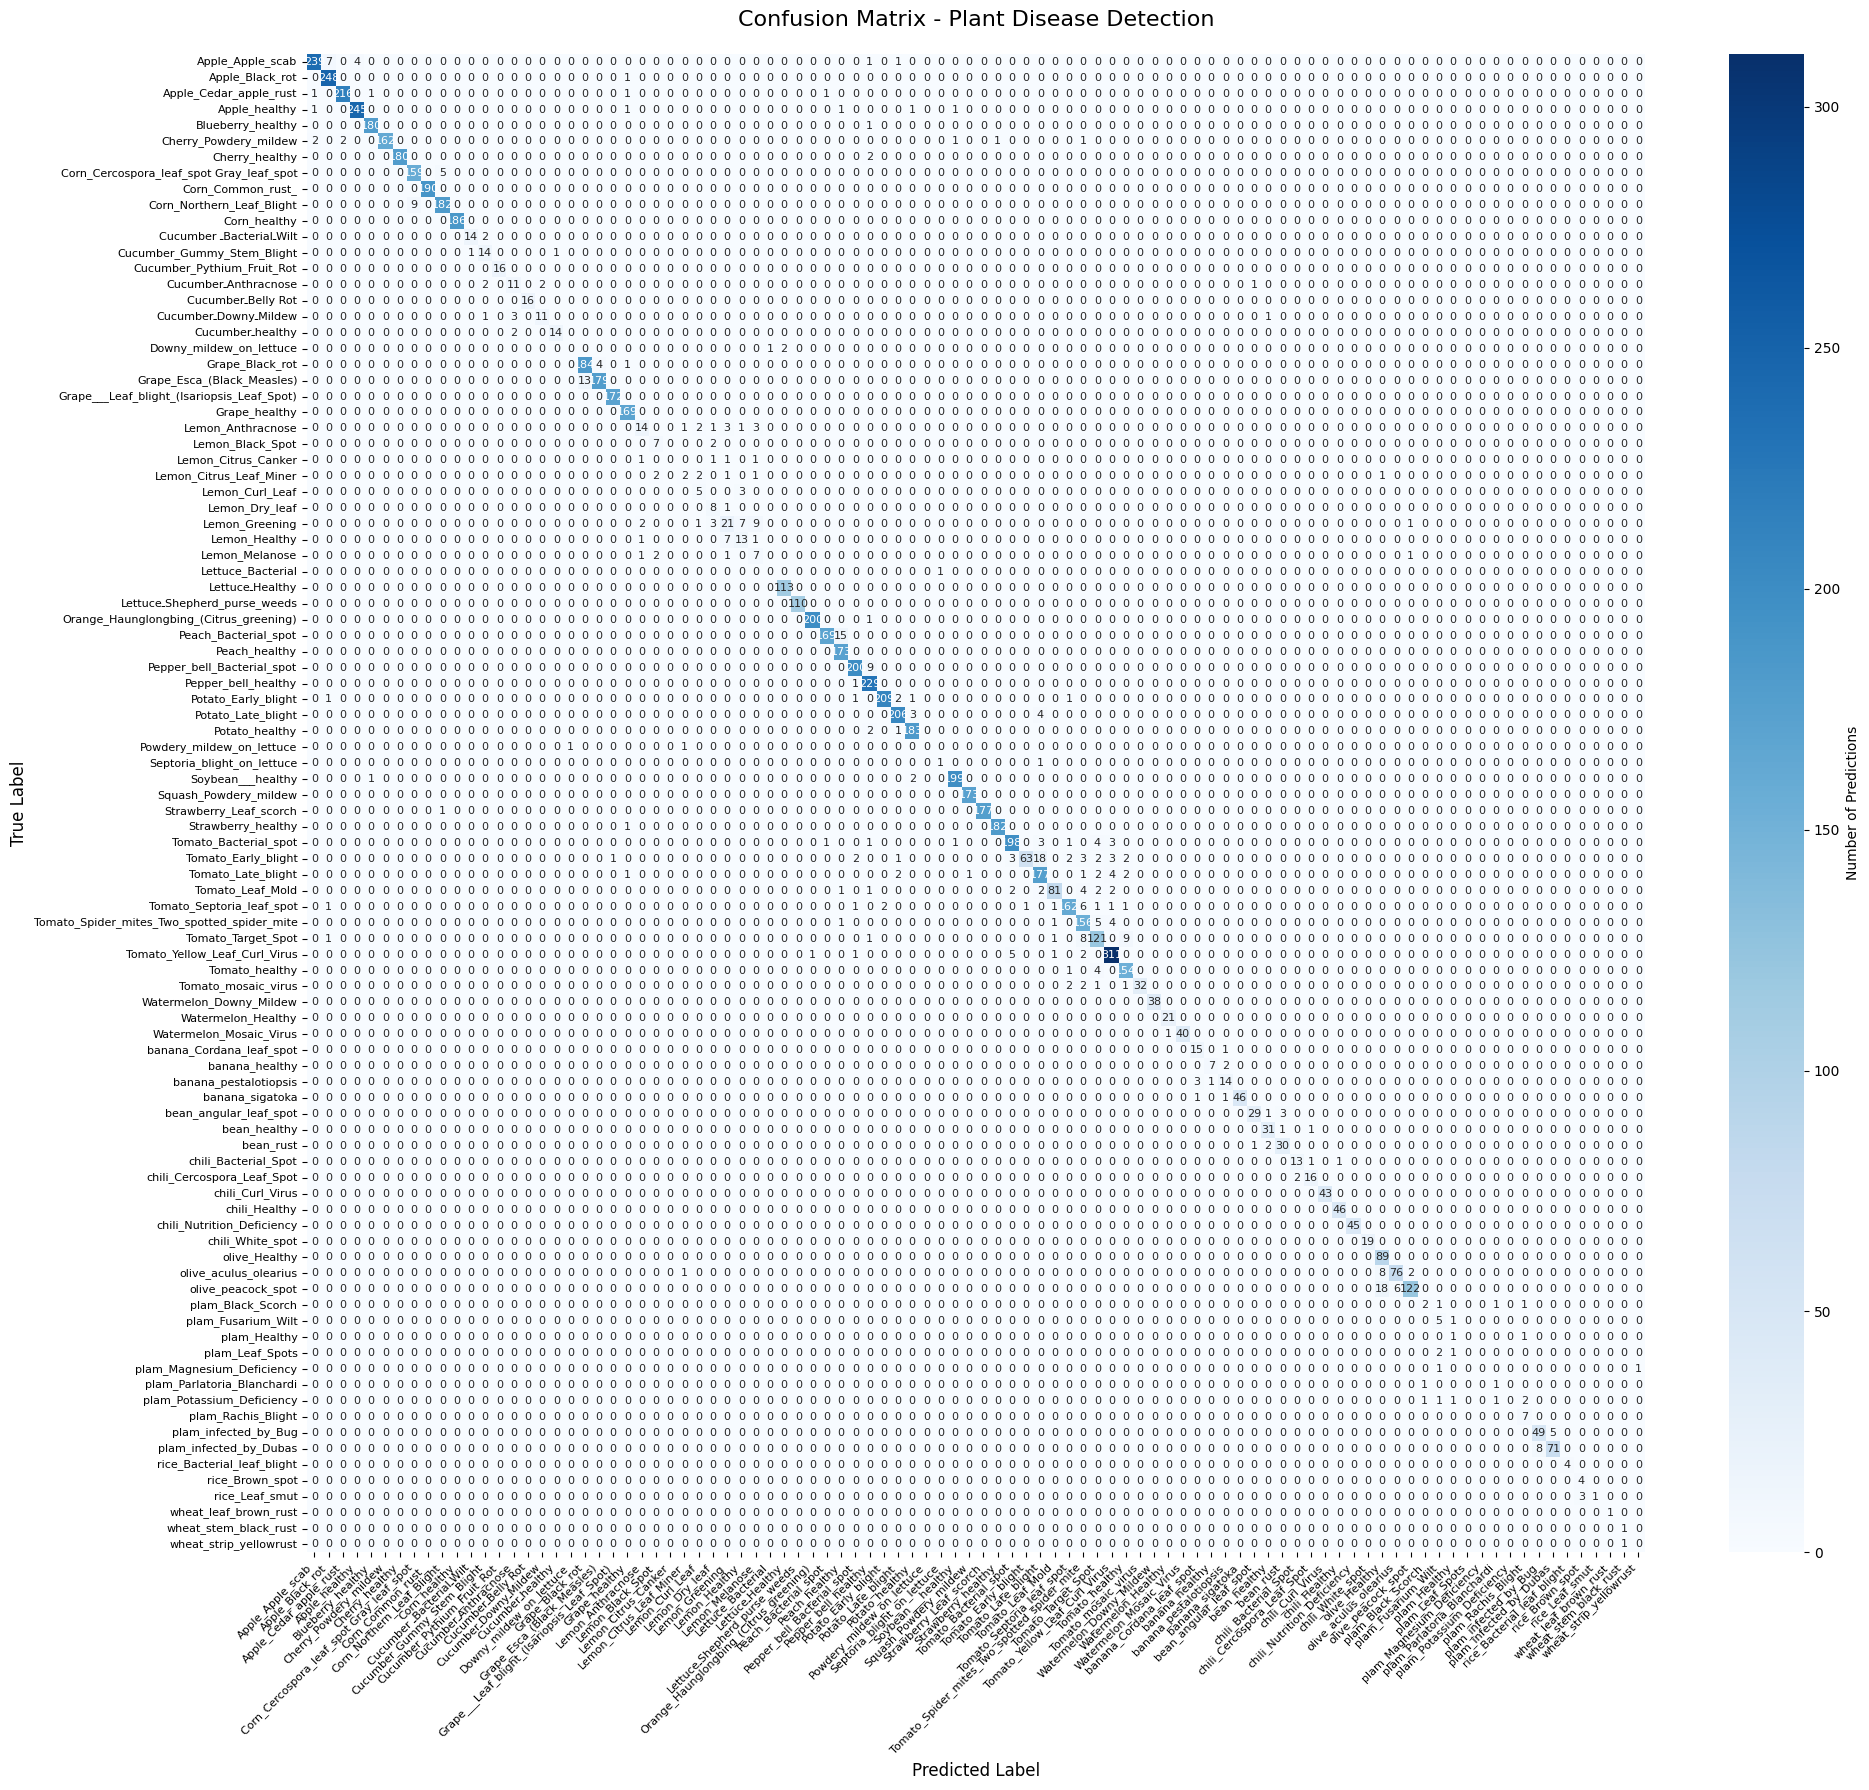


  Classes not present in test set:
   - Wilt_and_leaf_blight_on_lettuce
   - plam_Manganese_Deficiency


In [54]:
# Confusion Matrix & Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\n Generating predictions on test set...")

y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# الحصول على الكلاسات الموجودة فعلياً في Test Set
unique_classes_in_test = sorted(set(y_true))
class_names_in_test = [class_names[i] for i in unique_classes_in_test]

print(f" Total classes in dataset: {len(class_names)}")
print(f" Classes present in test set: {len(unique_classes_in_test)}")
print(f"  Missing classes: {len(class_names) - len(unique_classes_in_test)}")

# Classification Report
print("\n" + "="*70)
print(" CLASSIFICATION REPORT:")
print("="*70)
print(classification_report(
    y_true,
    y_pred,
    labels=unique_classes_in_test,
    target_names=class_names_in_test,
    digits=3,
    zero_division=0
))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=unique_classes_in_test)
plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_in_test,
            yticklabels=class_names_in_test,
            cbar_kws={'label': 'Number of Predictions'},
            annot_kws={'size': 8})
plt.title('Confusion Matrix - Plant Disease Detection', fontsize=16, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

# عرض الكلاسات الناقصة
missing_classes = set(range(len(class_names))) - set(unique_classes_in_test)
if missing_classes:
    print("\n  Classes not present in test set:")
    for idx in sorted(missing_classes):
        print(f"   - {class_names[idx]}")

In [55]:
def predict_with_confidence(img_path, model, class_names, show_top_n=5):
    """
    تتنبأ بالمرض من صورة وتعرض:
    - الصورة الأصلية
    - التنبؤ الأساسي مع نسبة الثقة
    - أعلى N تنبؤات محتملة
    """
    # تحميل الصورة
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # التنبؤ
    predictions = model.predict(img_array, verbose=0)[0]
    predicted_idx = np.argmax(predictions)
    predicted_class = class_names[predicted_idx]
    confidence = predictions[predicted_idx] * 100

    # ترتيب التنبؤات من الأعلى للأقل
    top_indices = np.argsort(predictions)[::-1][:show_top_n]

    # رسم النتائج
    fig = plt.figure(figsize=(16, 6))
    gs = fig.add_gridspec(1, 3, width_ratios=[1.5, 1, 1])

    # عرض الصورة
    ax1 = fig.add_subplot(gs[0])
    ax1.imshow(img)
    ax1.axis('off')

    # تحديد اللون حسب الثقة
    if confidence >= 80:
        color = '#2ecc71'  # أخضر
        status = 'High Confidence'
    elif confidence >= 60:
        color = '#f39c12'  # برتقالي
        status = ' Medium Confidence'
    else:
        color = '#e74c3c'  # أحمر
        status = ' Low Confidence'

    ax1.set_title(f"🌿 Predicted: {predicted_class}\n🎯 Confidence: {confidence:.2f}%\n{status}",
                  fontsize=13, pad=15, fontweight='bold', color=color)

    # عرض أعلى التنبؤات (Bar Chart)
    ax2 = fig.add_subplot(gs[1])
    top_classes = [class_names[i] for i in top_indices]
    top_confidences = [predictions[i] * 100 for i in top_indices]

    colors = ['#2ecc71' if i == 0 else '#3498db' if conf > 10 else '#95a5a6'
              for i, conf in enumerate(top_confidences)]
    bars = ax2.barh(range(show_top_n), top_confidences, color=colors)
    ax2.set_yticks(range(show_top_n))
    ax2.set_yticklabels([cls[:25] for cls in top_classes], fontsize=9)
    ax2.set_xlabel('Confidence (%)', fontsize=11)
    ax2.set_title(f'Top {show_top_n} Predictions', fontsize=12, fontweight='bold')
    ax2.set_xlim(0, 100)
    ax2.invert_yaxis()
    ax2.grid(axis='x', alpha=0.3)

    for i, (bar, conf) in enumerate(zip(bars, top_confidences)):
        ax2.text(conf + 1, i, f'{conf:.1f}%', va='center', fontsize=9, fontweight='bold')

    # عرض Distribution
    ax3 = fig.add_subplot(gs[2])
    all_confidences = sorted(predictions * 100, reverse=True)[:20]
    ax3.plot(range(len(all_confidences)), all_confidences,
             marker='o', linewidth=2, markersize=5, color='#3498db')
    ax3.fill_between(range(len(all_confidences)), all_confidences, alpha=0.3, color='#3498db')
    ax3.set_xlabel('Rank', fontsize=11)
    ax3.set_ylabel('Confidence (%)', fontsize=11)
    ax3.set_title('Prediction Distribution', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 100)

    plt.tight_layout()
    plt.show()

    # طباعة تقرير نصي
    print("\n" + "="*70)
    print("🔬 PREDICTION REPORT:")
    print("="*70)
    print(f" Primary Prediction: {predicted_class}")
    print(f" Confidence Level: {confidence:.2f}%")
    print(f" Confidence Status: {status}")
    print(f"\n Top {show_top_n} Possible Diseases:")
    for i, (cls, conf) in enumerate(zip(top_classes, top_confidences), 1):
        emoji = '🥇' if i == 1 else '🥈' if i == 2 else '🥉' if i == 3 else f'  {i}.'
        print(f"{emoji} {cls}: {conf:.2f}%")
    print("="*70)

    return predicted_class, confidence, dict(zip(top_classes, top_confidences))


 HOW TO USE THE PREDICTION FUNCTION:


/tmp/ipython-input-1768081533.py:76: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1768081533.py:76: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


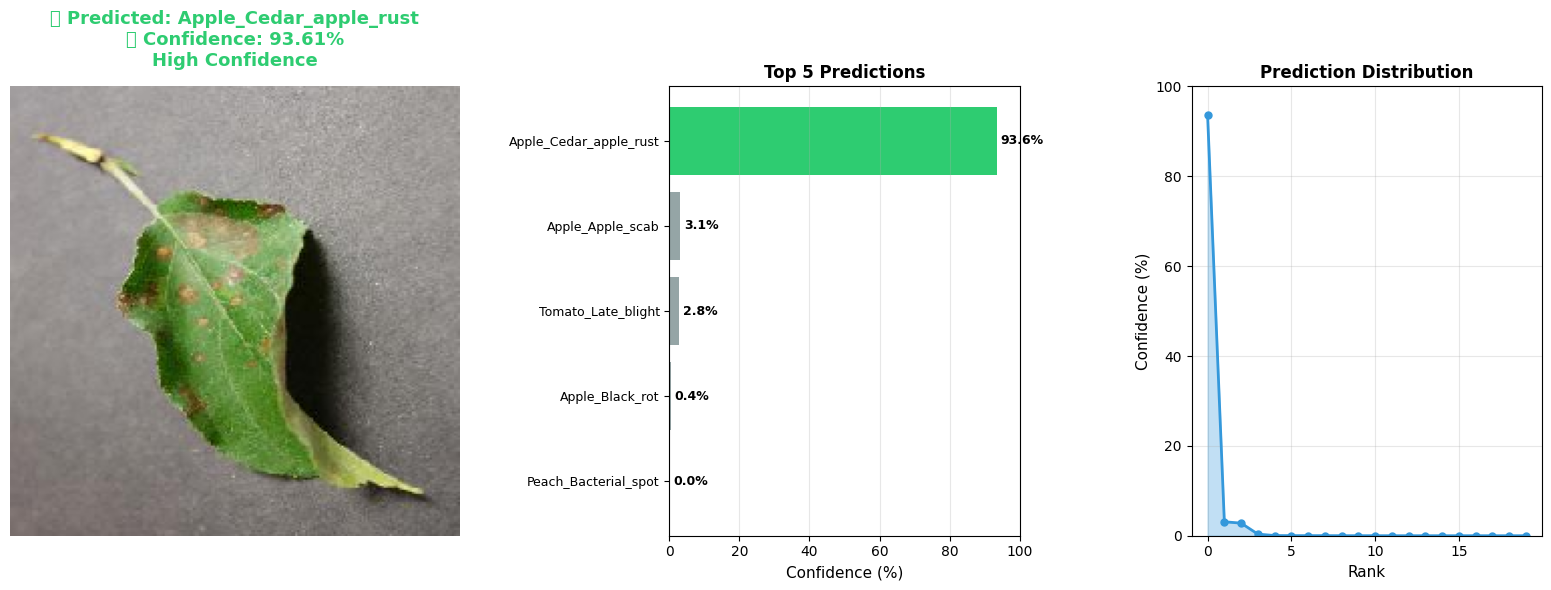


🔬 PREDICTION REPORT:
 Primary Prediction: Apple_Cedar_apple_rust
 Confidence Level: 93.61%
 Confidence Status: High Confidence

 Top 5 Possible Diseases:
🥇 Apple_Cedar_apple_rust: 93.61%
🥈 Apple_Apple_scab: 3.10%
🥉 Tomato_Late_blight: 2.80%
  4. Apple_Black_rot: 0.36%
  5. Peach_Bacterial_spot: 0.04%
('Apple_Cedar_apple_rust', np.float32(93.61342), {'Apple_Cedar_apple_rust': np.float32(93.61342), 'Apple_Apple_scab': np.float32(3.1047342), 'Tomato_Late_blight': np.float32(2.80238), 'Apple_Black_rot': np.float32(0.3604219), 'Peach_Bacterial_spot': np.float32(0.03872315)})


In [58]:
print("\n" + "="*70)
print(" HOW TO USE THE PREDICTION FUNCTION:")
print("="*70)
print(
# للتنبؤ على صورة جديدة (استبدلي المسار بمسارك إذا لزم):
predict_with_confidence('/content/drive/MyDrive/Ghiras_dataset/AppleCedarRust3.JPG', model, class_names)

)

/tmp/ipython-input-1768081533.py:76: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1768081533.py:76: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


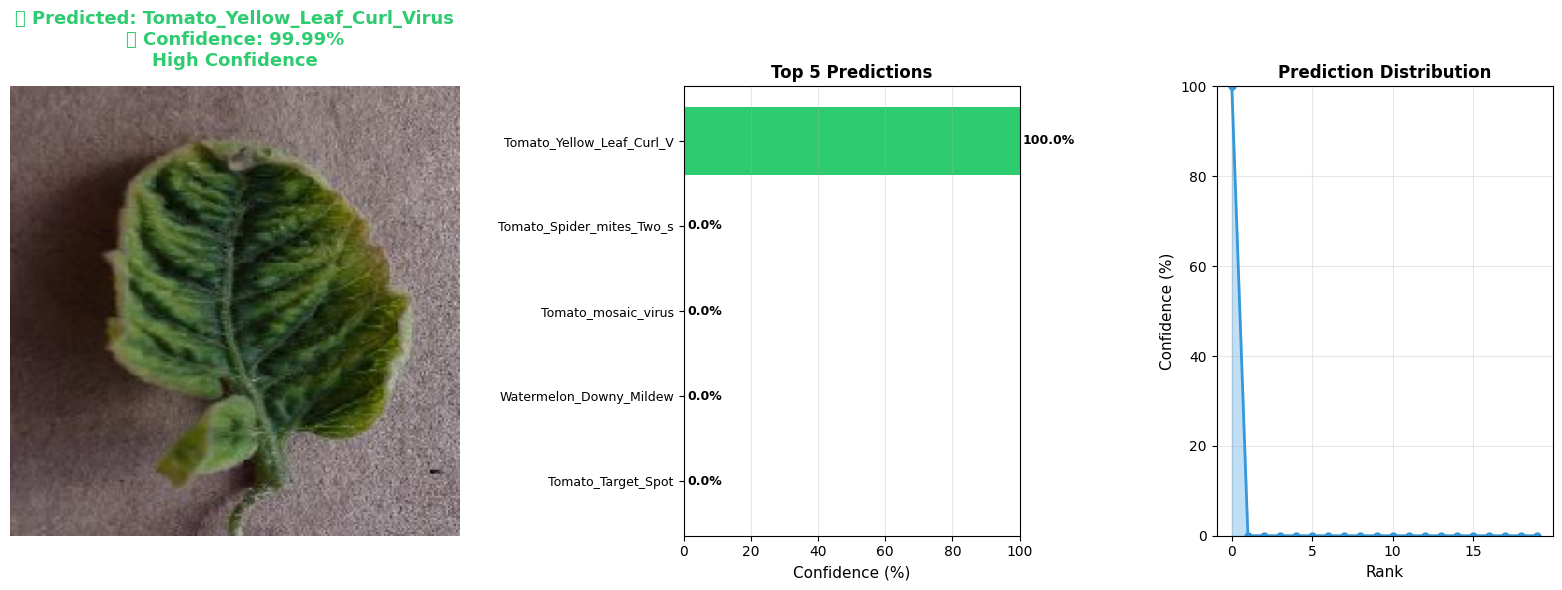


🔬 PREDICTION REPORT:
 Primary Prediction: Tomato_Yellow_Leaf_Curl_Virus
 Confidence Level: 99.99%
 Confidence Status: High Confidence

 Top 5 Possible Diseases:
🥇 Tomato_Yellow_Leaf_Curl_Virus: 99.99%
🥈 Tomato_Spider_mites_Two_spotted_spider_mite: 0.01%
🥉 Tomato_mosaic_virus: 0.00%
  4. Watermelon_Downy_Mildew: 0.00%
  5. Tomato_Target_Spot: 0.00%


('Tomato_Yellow_Leaf_Curl_Virus',
 np.float32(99.98926),
 {'Tomato_Yellow_Leaf_Curl_Virus': np.float32(99.98926),
  'Tomato_Spider_mites_Two_spotted_spider_mite': np.float32(0.007578874),
  'Tomato_mosaic_virus': np.float32(0.0020118493),
  'Watermelon_Downy_Mildew': np.float32(0.00037014286),
  'Tomato_Target_Spot': np.float32(0.00022027476)})

In [59]:

# مثال مع أعلى 5 احتمالات:
predict_with_confidence('/content/drive/MyDrive/Ghiras_dataset/TomatoYellowCurlVirus2.JPG', model, class_names, show_top_n=5)



/tmp/ipython-input-1768081533.py:76: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1768081533.py:76: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


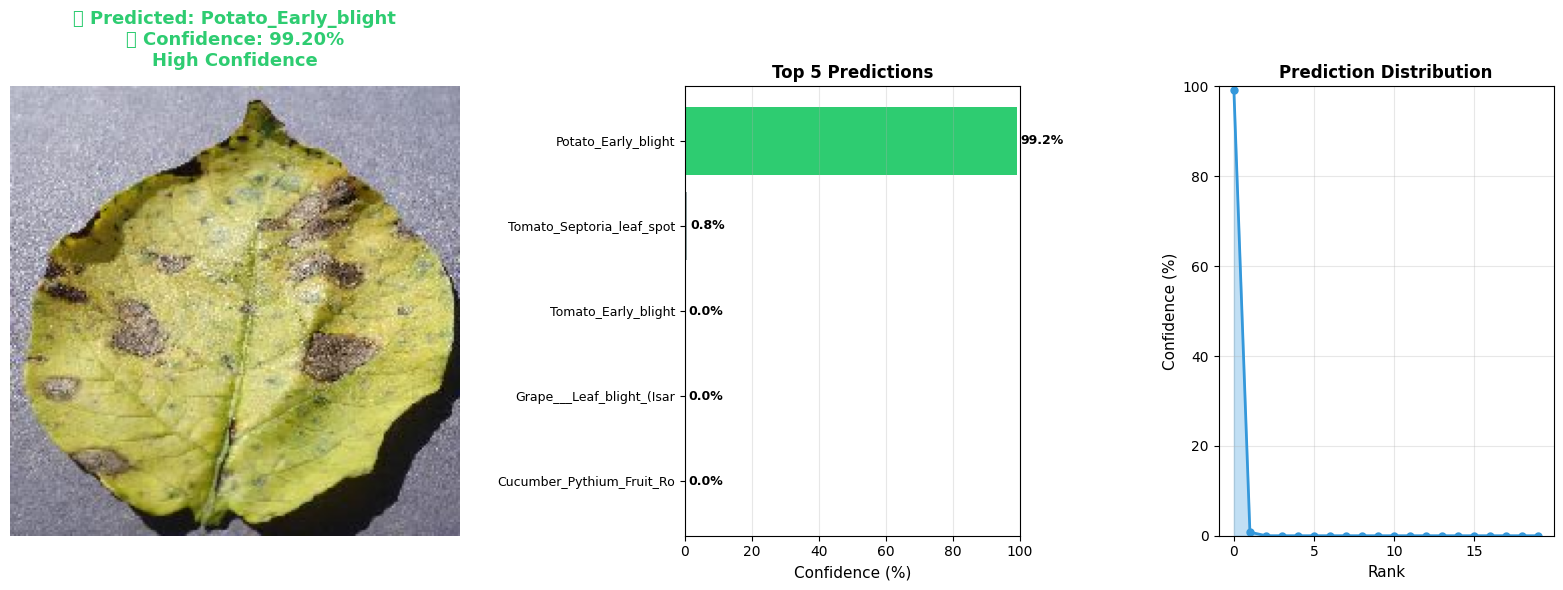


🔬 PREDICTION REPORT:
 Primary Prediction: Potato_Early_blight
 Confidence Level: 99.20%
 Confidence Status: High Confidence

 Top 5 Possible Diseases:
🥇 Potato_Early_blight: 99.20%
🥈 Tomato_Septoria_leaf_spot: 0.79%
🥉 Tomato_Early_blight: 0.00%
  4. Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 0.00%
  5. Cucumber_Pythium_Fruit_Rot: 0.00%


('Potato_Early_blight',
 np.float32(99.203026),
 {'Potato_Early_blight': np.float32(99.203026),
  'Tomato_Septoria_leaf_spot': np.float32(0.79477763),
  'Tomato_Early_blight': np.float32(0.0013960712),
  'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': np.float32(0.0006734613),
  'Cucumber_Pythium_Fruit_Rot': np.float32(4.883048e-05)})

In [60]:

# مثال إضافي:
predict_with_confidence('/content/drive/MyDrive/Ghiras_dataset/PotatoEarlyBlight4.JPG', model, class_names, show_top_n=5)

In [61]:
print("\n Saving final files...")
model.save('/content/final_model_transfer_learning.keras')
print("Model saved: /content/final_model_transfer_learning.keras")
print(" Best model saved: /content/best_model.keras")
print(" Class names saved: /content/class_names.json")

print("\n" + "="*70)
print(" TRANSFER LEARNING TRAINING COMPLETED SUCCESSFULLY!")
print("="*70)
print(f"\n Final Results Summary:")
print(f"   • Test Accuracy: {test_results[1]*100:.2f}%")
print(f"   • Test Top-5 Accuracy: {test_results[2]*100:.2f}%")
print(f"   • Total Classes: {num_classes}")
print(f"   • Model: EfficientNetB0 (Transfer Learning)")
print("="*70)


 Saving final files...
Model saved: /content/final_model_transfer_learning.keras
 Best model saved: /content/best_model.keras
 Class names saved: /content/class_names.json

 TRANSFER LEARNING TRAINING COMPLETED SUCCESSFULLY!

 Final Results Summary:
   • Test Accuracy: 94.78%
   • Test Top-5 Accuracy: 99.68%
   • Total Classes: 96
   • Model: EfficientNetB0 (Transfer Learning)


In [62]:
import os, shutil

save_dir = "/content/drive/MyDrive/Ghiras_dataset/exports"
os.makedirs(save_dir, exist_ok=True)

for p in [
    "/content/final_model_transfer_learning.keras",
    "/content/best_model.keras",
    "/content/class_names.json",
]:
    shutil.copy(p, save_dir)

print("Copied to:", save_dir)

Copied to: /content/drive/MyDrive/Ghiras_dataset/exports


In [63]:
from google.colab import files
files.download("/content/best_model.keras")
files.download("/content/final_model_transfer_learning.keras")
files.download("/content/class_names.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>